In [11]:
"""
Imports
"""
import numpy as np
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

In [4]:
"""
# object points represent the object's x,y,z coordinates in the real world,
as opposd to coordinates in the camera image.
Since the chessboard is 9 x 6, we will have 9*6 = 54 points, each with 3 coordinates.

Set the x,y coordinates to all the possible coordinates where
x ranges from 0 to 8 (left to right)
y ranges from 0 to 5 (top to bottom)
"""
objp = np.zeros((6*9,3), np.float32)
objp[0:2]

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)

In [15]:
"""
The next few steps are getting all combinations of x,y coordinates
where x is from 0 to 8 and y is from 0 to 5.
numpy.mgrid gives us a 2 x 9 x 6, where the 2 is for the x and the y coordinates
"""
objp_tmp = np.mgrid[0:9, 0:6]
objp_tmp

array([[[0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8]],

       [[0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5]]])

In [16]:
objp_tmp.shape

(2, 9, 6)

In [17]:
"""
Taking the transpose gives us a 6 x 9 x 2, so the x,y coordinates
are now paired together
"""
objp_tmp = objp_tmp.T
objp_tmp

array([[[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 0],
        [6, 0],
        [7, 0],
        [8, 0]],

       [[0, 1],
        [1, 1],
        [2, 1],
        [3, 1],
        [4, 1],
        [5, 1],
        [6, 1],
        [7, 1],
        [8, 1]],

       [[0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [5, 2],
        [6, 2],
        [7, 2],
        [8, 2]],

       [[0, 3],
        [1, 3],
        [2, 3],
        [3, 3],
        [4, 3],
        [5, 3],
        [6, 3],
        [7, 3],
        [8, 3]],

       [[0, 4],
        [1, 4],
        [2, 4],
        [3, 4],
        [4, 4],
        [5, 4],
        [6, 4],
        [7, 4],
        [8, 4]],

       [[0, 5],
        [1, 5],
        [2, 5],
        [3, 5],
        [4, 5],
        [5, 5],
        [6, 5],
        [7, 5],
        [8, 5]]])

In [18]:
objp_tmp.shape

(6, 9, 2)

In [19]:
"""
In order to flatten this 3d matrix to a 2D,
We specify that the inner-most dimension have 2 values (x,y),
and the outer dimension is however many rows that exist for
6 x 9 coordinates (54)
"""
objp_tmp = objp_tmp.reshape(-1,2)
objp_tmp

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [5, 2],
       [6, 2],
       [7, 2],
       [8, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3],
       [4, 3],
       [5, 3],
       [6, 3],
       [7, 3],
       [8, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [3, 4],
       [4, 4],
       [5, 4],
       [6, 4],
       [7, 4],
       [8, 4],
       [0, 5],
       [1, 5],
       [2, 5],
       [3, 5],
       [4, 5],
       [5, 5],
       [6, 5],
       [7, 5],
       [8, 5]])

In [20]:
objp_tmp.shape

(54, 2)

In [21]:
"""
Finally, set the first 2 values of objp, which are the x,y coordinates.
Notice that the 3rd z coordinate remains zero for all coordinates
"""
objp[:,:2] = objp_tmp
objp

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 8.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 8.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 8.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 8.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4.

In [22]:
objp.shape

(54, 3)

In [26]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [38]:
len(images)

20

In [39]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #print(corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
           
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        #cv2.waitKey(500)
    else:
        print("could not find corners for {}".format(fname))
    """
    """
cv2.destroyAllWindows()

could not find corners for camera_cal/calibration1.jpg
could not find corners for camera_cal/calibration4.jpg
could not find corners for camera_cal/calibration5.jpg


In [54]:
"""
Now objpoints has 17 copies of the points in the 'real world'
and imgpoints has 17 sets of coordinates for the found corners.
There are 9 * 6 = 54 corners for each set.  
Each corner is represented by two coordinates (x,y)

Using the sets of image and real points, we can calibrate the camera.

The camera calibration gives us matrices and vectors that are 
used to undistort any image taken with the same camera 
(the image size is also needed for calibration)

"""
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [56]:
#ret != 0 is True
ret

1.1868973603423718

In [57]:
mtx

array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
       [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [58]:
dist

array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

In [59]:
#rotation vectors
rvecs

[array([[ 0.50716545],
        [-0.22122219],
        [ 0.02988717]]), array([[ 0.03492402],
        [ 0.45739729],
        [ 0.00492867]]), array([[ 0.03471112],
        [ 0.65086688],
        [ 0.00971071]]), array([[-0.33084415],
        [ 0.65914967],
        [-0.41537657]]), array([[ 0.05531879],
        [-0.51892709],
        [-0.00398629]]), array([[-0.02434082],
        [-0.48814782],
        [ 0.0205404 ]]), array([[ 0.04125139],
        [-0.46371786],
        [-0.05619974]]), array([[ 0.21226762],
        [-0.067192  ],
        [ 0.0124846 ]]), array([[ 0.17850283],
        [-0.06187035],
        [ 0.00114955]]), array([[ 0.08447458],
        [ 0.38039934],
        [ 0.05427302]]), array([[ 0.63236599],
        [-0.04827079],
        [ 0.01721011]]), array([[-0.02563264],
        [ 0.38170173],
        [-0.00443487]]), array([[-0.44823487],
        [-0.06589252],
        [-0.01933811]]), array([[ 0.01805199],
        [ 0.02669678],
        [-0.00551439]]), array([[ 0.0178336 

In [60]:
#translation vectors
tvecs

[array([[ -2.11922855],
        [ -0.71465388],
        [ 19.53183554]]), array([[-16.99963028],
        [ -3.45711062],
        [ 31.88140225]]), array([[ -0.21898193],
        [ -3.45905797],
        [ 21.82352738]]), array([[ -6.06136681],
        [ -1.54277113],
        [ 26.6077651 ]]), array([[  5.35073144],
        [ -4.43439198],
        [ 20.69860635]]), array([[  4.46791786],
        [ -1.45553778],
        [ 19.91167384]]), array([[  4.86295442],
        [ -5.0332483 ],
        [ 19.69539304]]), array([[ -3.98286443],
        [ -1.31029172],
        [ 16.98785567]]), array([[ -3.63923607],
        [ -4.12214649],
        [ 17.72145269]]), array([[-13.0435234 ],
        [ -5.57212836],
        [ 23.64304788]]), array([[-3.83498058],
        [-1.59623848],
        [ 7.94136389]]), array([[-13.43070279],
        [ -0.45669297],
        [ 24.41876447]]), array([[ -4.40335216],
        [ -3.04835705],
        [ 10.68886726]]), array([[ -4.97952826],
        [ -3.83821782],
      

In [68]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_pickle.p", "wb" ) )

In [70]:
#loading dist_pickle from pickle file
import pickle
dist_pickle = pickle.load( open( "camera_cal/camera_pickle.p", "rb" ) )
dist_pickle

{'dist': array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
          -1.28318856e-04,   2.67125290e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
        [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

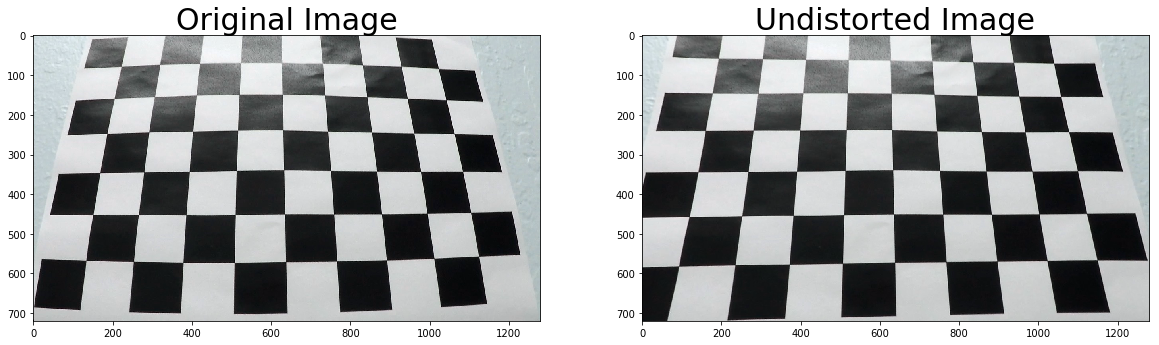

In [69]:
dst = cv2.undistort(img, dist_pickle['mtx'], dist_pickle['dist'], None, dist_pickle['mtx'])
cv2.imwrite('camera_cal/test_undist_3.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [18]:
import pickle
import sys

def undistort_image(x_count, y_count, img, use_cache=True, image_dir='camera_cal/calibration*.jpg'):
    """
    Get the mtx and dist matrices that are used to undistort an image.
    Either load these from a saved cache, or calculate them if needed.
    
    x_count: number of inside corners in x direction (left to right)
    y_count: number of inside corners in y direction (top to bottom)
    image_dir: path where chess board images are located: 'camera_cal/*.jpg'
    img_size: can either be (width, height), or (height, width). Both appear to work
    img: distorted image to undistort
    
    Returns:
    undist: undistorted image
    """
    pickle_path = "camera_cal/camera_pickle.p"
    if use_cache:
        try:
            dist_pickle = pickle.load( open( pickle_path, "rb" ) )
            print("using cached mtx, dst values to undistort image")
            return cv2.undistort(img, dist_pickle['mtx'], dist_pickle['dist'], None, dist_pickle['mtx'])
        except:
            print("error loading mtx and dst from cache, recalculating them...{}".format(sys.exc_info()))
    else:
        print("recalculating mtx and dst...")
    
    
    objp = np.zeros((x_count*y_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:x_count, 0:y_count].T.reshape(-1,2)
    images = glob.glob(image_dir)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img_tmp = cv2.imread(fname)
        gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x_count,y_count), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print("could not find corners for {}".format(fname))
    
    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    if ret:
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
        return cv2.undistort(img, mtx, dist, None, mtx)
    else:
        print("could not calibrate camera")
        return None

recalculating mtx and dst...
could not find corners for camera_cal/calibration1.jpg
could not find corners for camera_cal/calibration4.jpg
could not find corners for camera_cal/calibration5.jpg


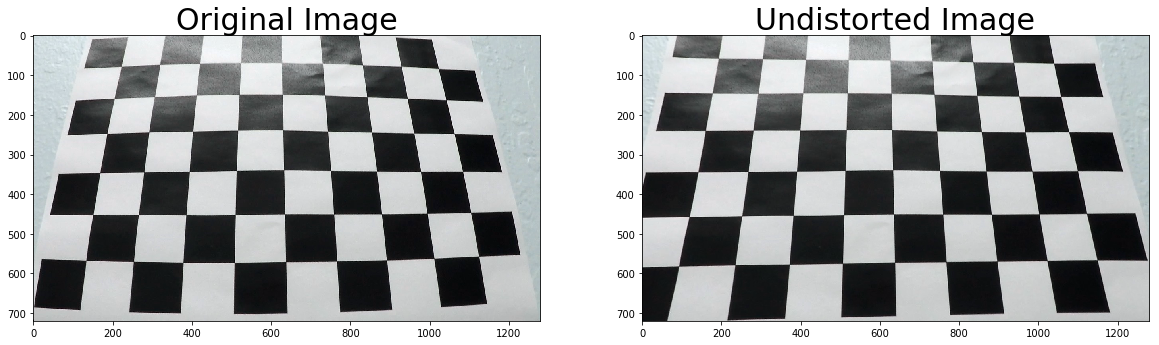

In [19]:
img = cv2.imread('camera_cal/calibration3.jpg')
dst = undistort_image(x_count=9,
                      y_count=6,
                      img=img,
                      use_cache=False,
                      image_dir='camera_cal/calibration*.jpg')
cv2.imwrite('camera_cal/test_undist_3.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);

using cached mtx, dst values to undistort image


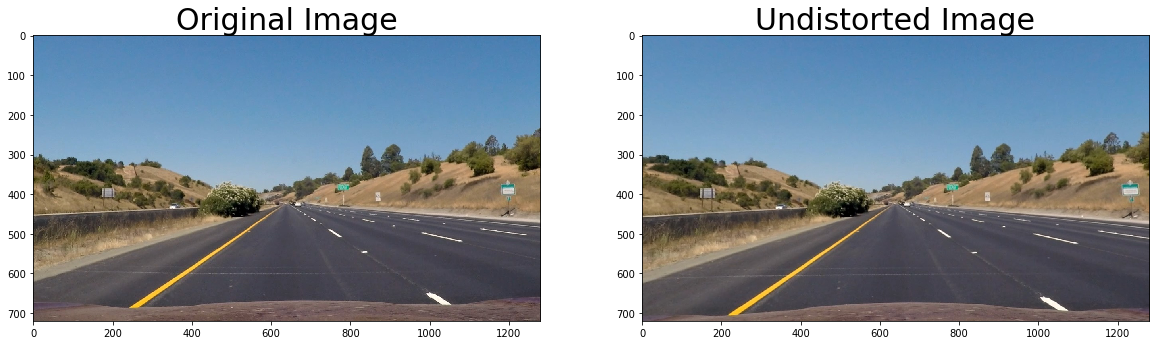

In [21]:
"""
undistort a road image
"""
import cv2
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
dst = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')
cv2.imwrite('/output_images/road_undistorted.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);